# Setup

In [37]:
using CSV
using DataFrames
using Images
using ImageAxes
using Flux
using Flux: onehotbatch, throttle, crossentropy, @epochs, onecold
using Base.Iterators: partition

# Load training data

In [2]:
train_images_df = CSV.File("./train_images.csv", datarow=1) |> DataFrame
test_images_df = CSV.File("./test_images.csv", datarow=1) |> DataFrame
"done"

"done"

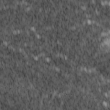

In [3]:
function process_images(images_df)
    images_arr = convert(Array, images_df)
    AxisArray(
        Gray{N0f8}.(reshape(images_arr' / 255, 110, 110, :)),
        :h, :w, :i)
end
images_train = process_images(train_images_df)
images_test = process_images(test_images_df)

images_train[Axis{:i}(2)]

# Load labels

In [4]:
train_labels_df = CSV.File("./train_labels.csv") |> DataFrame
test_labels_df = CSV.File("./test_labels.csv") |> DataFrame
"done"

"done"

In [5]:
function onehot_targets(labels_df)
    targets = labels_df[Symbol("Number Volcanoes")]
    targets = [isnan(x) ? 0.0 : 1.0 for x = targets]
    onehotbatch(targets, 0:1)
end

targets_train = onehot_targets(train_labels_df)
targets_test = onehot_targets(test_labels_df)
println(size(targets_train))
targets_train[:, 1:10]

(2, 7000)


2×10 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 false   true   true   true   true   true   true   true   true  false
  true  false  false  false  false  false  false  false  false   true

# Verify the inputs are aligned well

In [6]:
function prepare_inputs(images, targets, batch_size)
    reshaped_images = reshape(float.(images), (110, 110, 1, :))
    [(reshaped_images[:, :, :, i], targets[:, i])
         for i in partition(1:last(size(images)), batch_size)]
end

train = prepare_inputs(images_train, targets_train, 100)
test = prepare_inputs(images_test, targets_test, 100)

28-element Array{Tuple{Array{Float64,4},Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}},1}:
 ([0.419608 0.396078 … 0.388235 0.388235; 0.454902 0.415686 … 0.415686 0.435294; … ; 0.376471 0.34902 … 0.494118 0.509804; 0.407843 0.364706 … 0.521569 0.52549]

[0.364706 0.356863 … 0.341176 0.360784; 0.372549 0.364706 … 0.384314 0.341176; … ; 0.313725 0.329412 … 0.4 0.360784; 0.301961 0.32549 … 0.411765 0.443137]

[0.423529 0.439216 … 0.541176 0.521569; 0.423529 0.317647 … 0.509804 0.521569; … ; 0.482353 0.482353 … 0.572549 0.513725; 0.517647 0.427451 … 0.447059 0.541176]

...

[0.305882 0.258824 … 0.364706 0.34902; 0.345098 0.290196 … 0.341176 0.360784; … ; 0.376471 0.447059 … 0.392157 0.313725; 0.415686 0.423529 … 0.384314 0.32549]

[0.419608 0.427451 … 0.439216 0.45098; 0.431373 0.407843 … 0.45098 0.509804; … ; 0.415686 0.380392 … 0.407843 0.435294; 0.352941 0.384314 … 0.439216 0.478431]

[0.494118 0.494118 … 0.52549 0.478431; 0.482353 0.509804 … 0.462745 0.490196; … ; 0.470588 0.505882 … 0.

# Start modeling

Now that we have some data, let's start doing the ML

In [69]:
cnn = Chain(
    BatchNorm(1),
    Conv((2, 2), 1=>8, relu),
    x -> maxpool(x, (2, 2)),
    BatchNorm(8),
    Conv((2, 2), 8=>16, relu),
    x -> maxpool(x, (2, 2)),
    BatchNorm(16),
    Conv((2, 2), 16=>16, relu),
    x -> maxpool(x, (2, 2)),
    BatchNorm(16),
    Conv((2, 2), 16=>4, relu),
    x -> maxpool(x, (2, 2)),
    BatchNorm(4),
    x -> reshape(x, :, size(x, 4)),
    BatchNorm(100),
    Dense(100, 2),
    BatchNorm(2),
    softmax)

@time cnn(train[1][1])

  1.583583 seconds (3.80 M allocations: 766.419 MiB, 49.06% gc time)


Tracked 2×100 Array{Float64,2}:
 0.891533  0.695322  0.562673  0.2415  …  0.152704  0.396471  0.578118
 0.108467  0.304678  0.437327  0.7585     0.847296  0.603529  0.421882

In [81]:
baseline = Chain(
    x -> reshape(x, :, size(x, 4)),
    Dense(110*110, 2),
    BatchNorm(2),
    softmax)
@time baseline(train[1][1])

  0.006208 seconds (3.73 k allocations: 174.729 KiB)


Tracked 2×100 Array{Float64,2}:
 0.129814  0.368872  0.623537  0.456982  …  0.55431  0.0521616  0.293199
 0.870186  0.631128  0.376463  0.543018     0.44569  0.947838   0.706801

In [82]:
function train_model(m)
    loss(x, y) = crossentropy(m(x), y)

    mean(x) = sum(x) / length(x)
    accuracy(x, y) = mean(onecold(m(x)) .== onecold(y))

    Xt_ = test[1][1]
    Yt_ = test[1][2]
    function callback()
        @show loss(Xt_, Yt_)
        @show accuracy(Xt_, Yt_)
    end

    evalcb = throttle(callback, 100)

    opt = ADAM(params(m), 0.1)

    @epochs 10 Flux.train!(loss, train, opt, cb = evalcb)
    
    println("Final accuracy: $(accuracy())")
end

train_model (generic function with 1 method)

In [83]:
train_model(baseline)

┌ Info: Epoch 1
└ @ Main /home/peterjdolan/.julia/packages/Flux/oN61x/src/optimise/train.jl:93


loss(Xt_, Yt_) = 0.6245574707418318 (tracked)
accuracy(Xt_, Yt_) = 0.86


┌ Info: Epoch 2
└ @ Main /home/peterjdolan/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 3
└ @ Main /home/peterjdolan/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 4
└ @ Main /home/peterjdolan/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 5
└ @ Main /home/peterjdolan/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 6
└ @ Main /home/peterjdolan/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 7
└ @ Main /home/peterjdolan/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 8
└ @ Main /home/peterjdolan/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 9
└ @ Main /home/peterjdolan/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
┌ Info: Epoch 10
└ @ Main /home/peterjdolan/.julia/packages/Flux/oN61x/src/optimise/train.jl:93
